_This notebook contains code and comments from Section 4.3 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 4.3 AdaBoost in Practice

AdaBoost is especially susceptible to outliers. Outliers are often misclassified by weak learners. Recall that AdaBoost increases the weight of misclassified examples. This means that the weight assigned to outliers continues to increase. When the next weak learner is trained
 * it continues to misclassify the outlier, in which case AdaBoost will increase its weight further, which in turn, causes succeeding weak learners to misclassify, fail and keep growing its weight, or
 * it correctly classifies the outlier, in which case AdaBoost has just overfit the data.
 
We visualize this behavior in the example below, where we observe that outliers force AdaBoost to spend a disproportionate amount of effort on training examples that are noisy. Put another way, outliers tend to confound AdaBoost and make it less robust. 

In [3]:
import numpy as np
from sklearn.datasets import make_moons

# Generate some data
X, y = make_moons(n_samples=100, noise=0.05)

# Add an outlier
X = np.concatenate((X, [[-1.15, 0.8]]))
y = np.concatenate((y, [1]))

# Convert to -1/+1 labels from 0/1 labels
y = 2 * y - 1  

In [7]:
import matplotlib.pyplot as plt

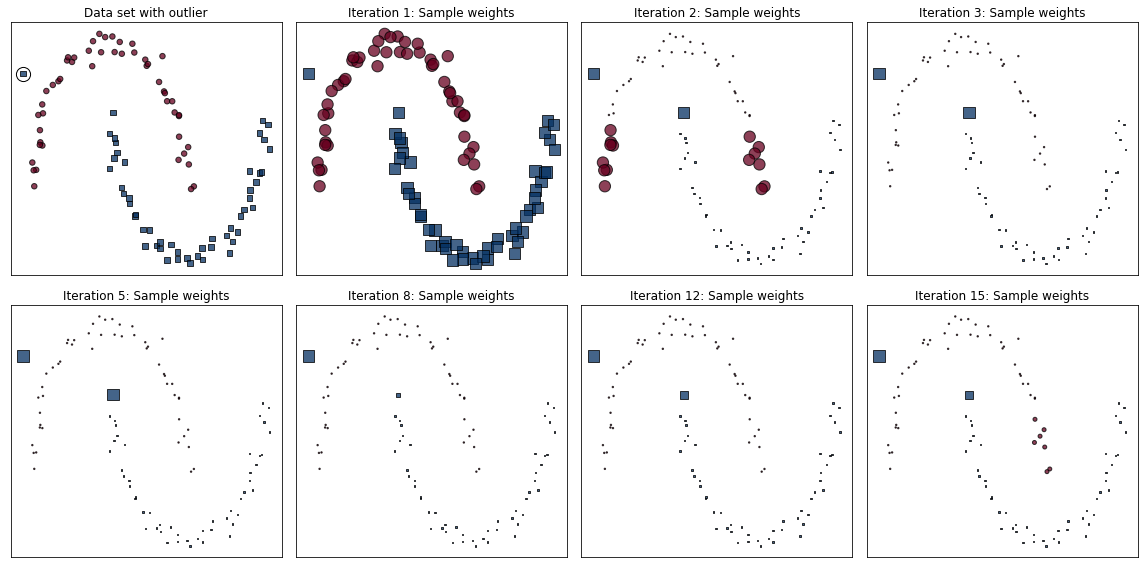

In [20]:
%matplotlib inline

from visualization import plot_2d_data, plot_2d_classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

n_samples, n_features = X.shape
n_estimators = 20
D = np.ones((n_samples, ))                      # Initialize example weights
ensemble = []                                   # Initialize an empty ensemble

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Plot the data set 
ax[0, 0].scatter([-1.15], [0.8], marker='o', s=200, c='w', edgecolors='k')
plot_2d_data(ax[0, 0], X, y, alpha=0.75, s=30,
             title='Data set with outlier', colormap='RdBu')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
axis_index = 0

for t in range(n_estimators):
    D = D / np.sum(D)                           # Normalize the sample weights

    # -- Plot the training examples in different sizes proportional to their weights
    s = D / np.max(D)
    s[(0.00 <= s) & (s < 0.25)] = 2
    s[(0.25 <= s) & (s < 0.50)] = 16
    s[(0.50 <= s) & (s < 0.75)] = 64
    s[(0.75 <= s) & (s <= 1.00)] = 128

    if t in [0, 1, 2, 4, 7, 11, 14]:
        axis_index += 1
        r, c = np.divmod(axis_index, 4)
        title = 'Iteration {0}: Sample weights'.format(t + 1)
        plot_2d_data(ax[r, c], X, y, alpha=0.75, s=s, title=title, colormap='RdBu')
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        
    h = DecisionTreeClassifier(max_depth=1)  # Initialize a decision stump
    h.fit(X, y, sample_weight=D)                # Train a weak learner using sample weights
    ypred = h.predict(X)                        # Predict using the weak learner

    e = 1 - accuracy_score(y, ypred, sample_weight=D)   # Weighted error of the weak learner
    a = 0.5 * np.log((1 - e) / e)               # Weak learner weight

    m = (y == ypred) * 1 + (y != ypred) * -1    # Identify correctly classified and misclassified points
    D *= np.exp(-a * m)                         # Update the sample weights

    ensemble.append((a, h))                     # Save the weighted weak hypothesis
    
fig.tight_layout()
pngFile = './figures/CH04_F10_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 4.3.1 Learning Rate

Now, we look at ways in which we can train robust models with AdaBoost. The first aspect we can control is [learning rate](https://scikit-learn.org/stable/modules/ensemble.html#shrinkage-via-learning-rate), which adjusts the contribution of each estimator to the ensemble.

For example, a learning rate of 0.75 tells AdaBoost to decrease the overall contribution of each base estimator by a factor of 0.75. When there are outliers, a high learning rate will cause their influence to grow proportionally quickly, which can absolutely kill the performance of your model. Therefore, one way to mitigate the effect of outliners is to lower the learning rate. 

In [22]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

**Listing 4.3**: Cross validation to select the best learning rate

We use [``StratifiedKFold``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) cross validation to ensure that the subsets preserve the percentage of samples for each class.

In [28]:
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

from visualization import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

# Initialize
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)

splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))

# Train AdaBoostClassifier for different learning rates and plot the results
stump = DecisionTreeClassifier(max_depth=1)
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump, n_estimators=10, learning_rate=rate)
        model.fit(X[trn, :], y[trn])

        trn_err[i, j] = (1 - accuracy_score(y[trn], model.predict(X[trn, :]))) * 100
        val_err[i, j] = (1 - accuracy_score(y[val], model.predict(X[val, :]))) * 100

        
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

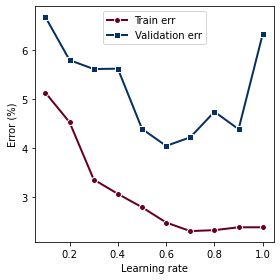

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()
pngFile = './figures/CH04_F11_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

### 4.3.2	Early Stopping and Pruning

Besides the learning_rate, the other important consideration for practical boosting is the number of base learners, n_estimators. It might be tempting to try to build an ensemble with a very large number of weak learners. However, this does not always translate to the best generalization performance.

In fact, it is often the case that we can achieve roughly the same performance with fewer base estimators than we think we might need. Identifying the least number of base estimators in order to build an effective ensemble is known as early stopping. 

**Listing 4.4**: Cross validation to select the best number of weak learners

In [38]:
n_estimator_steps, n_folds = 5, 10
number_of_stumps = np.arange(5, 50, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump,
                                   n_estimators=n_stumps, learning_rate=1.0)
        model.fit(X[trn, :], y[trn])

        trn_err[i, j] = 1 - accuracy_score(y[trn], 
                                           model.predict(X[trn, :]))
        val_err[i, j] = 1 - accuracy_score(y[val], 
                                           model.predict(X[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

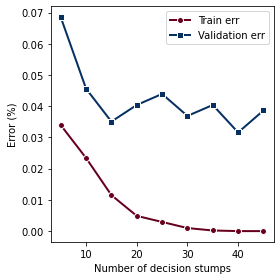

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Number of decision stumps')
ax.set_ylabel('Error (%)')

fig.tight_layout()
pngFile = './figures/CH04_F12_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)